In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget

# --- parameters ---
m = 10.0
k = 1.0
gamma = 0.1      # damping coefficient
kB = 1.0
T  = 1.0

tmax = 100.0
dt = 0.01
t = np.arange(0, tmax + dt, dt)
Nt = len(t)

Ntraj = 2000

# --- equilibrium initial conditions (canonical) ---
omega0 = np.sqrt(k/m)
x0 = np.random.normal(0.0, np.sqrt(kB*T/k), size=Ntraj)
v0 = np.random.normal(0.0, np.sqrt(kB*T/m), size=Ntraj)

# --- simulate Langevin dynamics ---
x = np.zeros((Ntraj, Nt))
v = np.zeros((Ntraj, Nt))
x[:, 0] = x0
v[:, 0] = v0

sigma = np.sqrt(2 * gamma * kB * T / m**2)  # noise prefactor in dv

sqrt_dt = np.sqrt(dt)
for n in range(Nt - 1):
    # dv = (-(gamma/m) v - (k/m) x) dt + sigma dW
    dW = np.random.normal(0.0, 1.0, size=Ntraj) * sqrt_dt
    v[:, n+1] = v[:, n] + (-(gamma/m)*v[:, n] - (k/m)*x[:, n]) * dt + sigma * dW
    x[:, n+1] = x[:, n] + v[:, n+1] * dt  # semi-implicit update

# --- two-time correlation matrix ---
C = (x.T @ x) / Ntraj
diag = np.sqrt(np.diag(C))
Cnorm = C / (diag[:, None] * diag[None, :])

# --- plot ---
fig, axes = plt.subplots(1, 2, figsize=(11, 4), constrained_layout=False)

im0 = axes[0].imshow(C, origin="lower", aspect="auto",
                     extent=[t[0], t[-1], t[0], t[-1]],cmap="plasma")
axes[0].set_title("Damped Langevin: C(t1,t2)")
axes[0].set_xlabel("t2"); axes[0].set_ylabel("t1")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(Cnorm, origin="lower", aspect="auto",
                     extent=[t[0], t[-1], t[0], t[-1]], vmin=-1, vmax=1,cmap="plasma")
axes[1].set_title("Normalized two-time map")
axes[1].set_xlabel("t2"); axes[1].set_ylabel("t1")
plt.colorbar(im1, ax=axes[1])

plt.show()



RuntimeError: 'widget' is not a recognised GUI loop or backend name

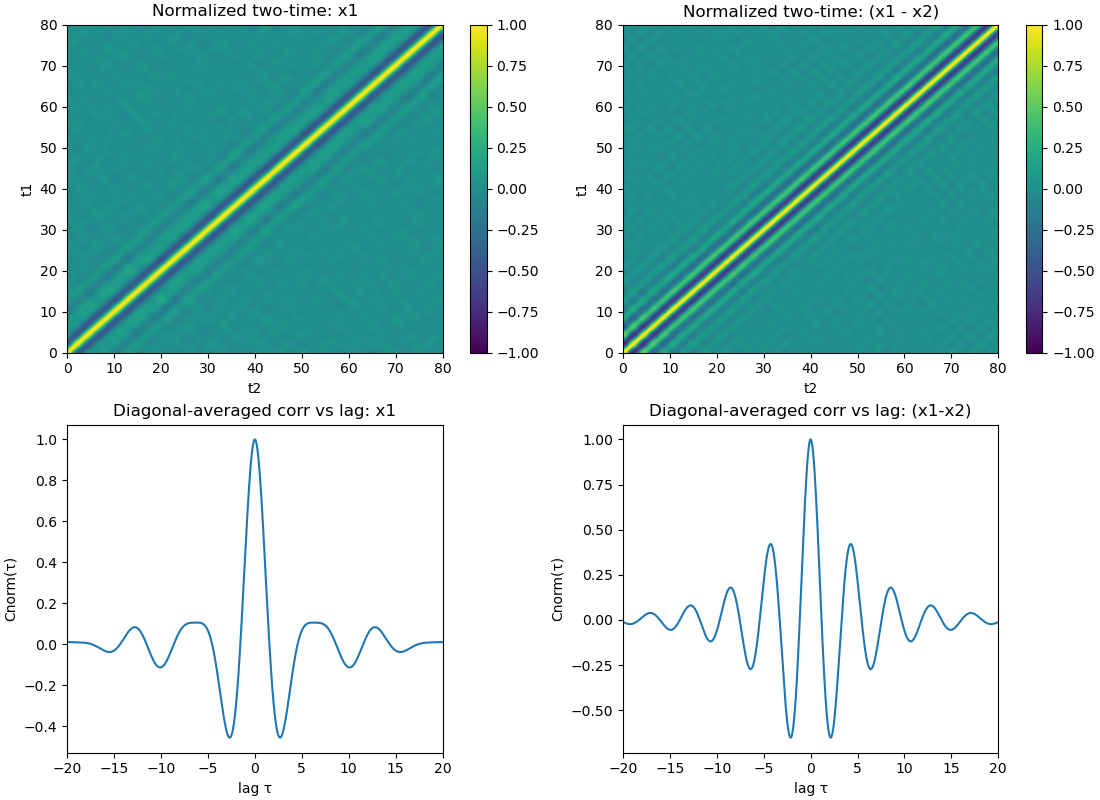

In [12]:
# -----------------------
# params
m = 1.0
k = 1.0
kc = 0.6          # coupling spring
gamma = 0.4       # damping
kB = 1.0
T  = 1.0

dt = 0.01
tmax = 80.0
t = np.arange(0, tmax + dt, dt)
Nt = len(t)

Ntraj = 2000      # ensemble size
# -----------------------

# equilibrium initial conditions (a decent approximation; dynamics will thermalize anyway)
x1 = np.random.normal(0.0, np.sqrt(kB*T/k), size=(Ntraj, Nt))
x2 = np.random.normal(0.0, np.sqrt(kB*T/k), size=(Ntraj, Nt))
v1 = np.random.normal(0.0, np.sqrt(kB*T/m), size=(Ntraj, Nt))
v2 = np.random.normal(0.0, np.sqrt(kB*T/m), size=(Ntraj, Nt))

# initialize at n=0 only
x1[:, 1:] = 0.0; x2[:, 1:] = 0.0
v1[:, 1:] = 0.0; v2[:, 1:] = 0.0

# noise scale in dv
sigma = np.sqrt(2 * gamma * kB * T / m**2)
sqrt_dt = np.sqrt(dt)

for n in range(Nt - 1):
    # forces (linear)
    f1 = -(k + kc) * x1[:, n] + kc * x2[:, n]
    f2 = -(k + kc) * x2[:, n] + kc * x1[:, n]

    dW1 = np.random.normal(0.0, 1.0, size=Ntraj) * sqrt_dt
    dW2 = np.random.normal(0.0, 1.0, size=Ntraj) * sqrt_dt

    # velocity update
    v1[:, n+1] = v1[:, n] + (f1/m - (gamma/m)*v1[:, n]) * dt + sigma * dW1
    v2[:, n+1] = v2[:, n] + (f2/m - (gamma/m)*v2[:, n]) * dt + sigma * dW2

    # position update (semi-implicit)
    x1[:, n+1] = x1[:, n] + v1[:, n+1] * dt
    x2[:, n+1] = x2[:, n] + v2[:, n+1] * dt

# choose an observable:
#   - x1 : "one domain"
#   - x1-x2 : relative coordinate (often cleaner; it's one normal mode)
obs1 = x1
obs_rel = x1 - x2

def two_time_matrix(x):
    C = (x.T @ x) / x.shape[0]
    diag = np.sqrt(np.diag(C))
    Cn = C / (diag[:, None] * diag[None, :])
    return C, Cn

C1, C1n = two_time_matrix(obs1)
Cr, Crn = two_time_matrix(obs_rel)

# plot
fig, ax = plt.subplots(2, 2, figsize=(11, 8), constrained_layout=True)

im = ax[0,0].imshow(C1n, origin="lower", aspect="auto",
                   extent=[t[0], t[-1], t[0], t[-1]], vmin=-1, vmax=1)
ax[0,0].set_title("Normalized two-time: x1")
ax[0,0].set_xlabel("t2"); ax[0,0].set_ylabel("t1")
plt.colorbar(im, ax=ax[0,0])

im = ax[0,1].imshow(Crn, origin="lower", aspect="auto",
                   extent=[t[0], t[-1], t[0], t[-1]], vmin=-1, vmax=1)
ax[0,1].set_title("Normalized two-time: (x1 - x2)")
ax[0,1].set_xlabel("t2"); ax[0,1].set_ylabel("t1")
plt.colorbar(im, ax=ax[0,1])

# also show 1D autocorrelations vs lag for intuition
# (extract along a fixed t1 index, or average over t1)
def corr_vs_lag(C):
    # average over diagonals -> function of lag
    lags = np.arange(-(Nt-1), Nt)
    vals = np.zeros_like(lags, dtype=float)
    counts = np.zeros_like(lags, dtype=float)
    for i in range(Nt):
        for j in range(Nt):
            lag = j - i
            idx = lag + (Nt-1)
            vals[idx] += C[i, j]
            counts[idx] += 1
    return lags * dt, vals / counts

lag, c1 = corr_vs_lag(C1n)
_,   cr = corr_vs_lag(Crn)

ax[1,0].plot(lag, c1)
ax[1,0].set_title("Diagonal-averaged corr vs lag: x1")
ax[1,0].set_xlabel("lag τ"); ax[1,0].set_ylabel("Cnorm(τ)")
ax[1,0].set_xlim(-20, 20)

ax[1,1].plot(lag, cr)
ax[1,1].set_title("Diagonal-averaged corr vs lag: (x1-x2)")
ax[1,1].set_xlabel("lag τ"); ax[1,1].set_ylabel("Cnorm(τ)")
ax[1,1].set_xlim(-20, 20)

plt.show()


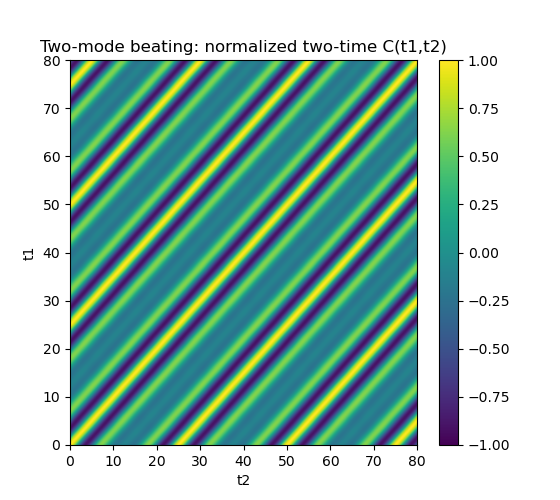

In [13]:
# ----- time axis -----
tmax = 80.0
Nt = 400
t = np.linspace(0, tmax, Nt)

# ----- two mode parameters -----
w1 = 2*np.pi*0.12   # rad/s  (frequency f1 = 0.12 Hz)
w2 = 2*np.pi*0.16   # rad/s  (frequency f2 = 0.16 Hz)
A1, A2 = 1.0, 0.9

# weak damping in the *correlations* via per-trajectory OU-ish envelope:
# easiest way: multiply each trajectory by exp(-gamma*t) and re-normalize later
gamma = 0.00  # set ~0.005–0.02 if you want visible fading with time

Ntraj = 5000

# random phases give an ensemble (like many coherence volumes / many initial conditions)
phi1 = np.random.uniform(0, 2*np.pi, size=Ntraj)[:, None]
phi2 = np.random.uniform(0, 2*np.pi, size=Ntraj)[:, None]

# build trajectories
x = (A1*np.cos(w1*t[None, :] + phi1) +
     A2*np.cos(w2*t[None, :] + phi2))

if gamma > 0:
    x = x * np.exp(-gamma*t[None, :])

# optional additive measurement noise
noise = 0.0
if noise > 0:
    x = x + noise*np.random.normal(size=x.shape)

# ----- two-time correlation matrix -----
C = (x.T @ x) / Ntraj

# normalized (like a typical two-time "g2-style" normalization)
diag = np.sqrt(np.diag(C))
Cn = C / (diag[:, None] * diag[None, :])

# ----- plot -----
plt.figure(figsize=(5.6, 5.0))
im = plt.imshow(Cn, origin="lower", aspect="auto",
                extent=[t[0], t[-1], t[0], t[-1]],
                vmin=-1, vmax=1)
plt.title("Two-mode beating: normalized two-time C(t1,t2)")
plt.xlabel("t2")
plt.ylabel("t1")
plt.colorbar(im)
plt.show()
